In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow.keras.backend as K
import cv2
import os
from PIL import Image
import random
import imghdr
import pickle

import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

### Specify directories

In [3]:
X_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images'
y_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs'

X_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X'
y_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/y'

### Visualization of data

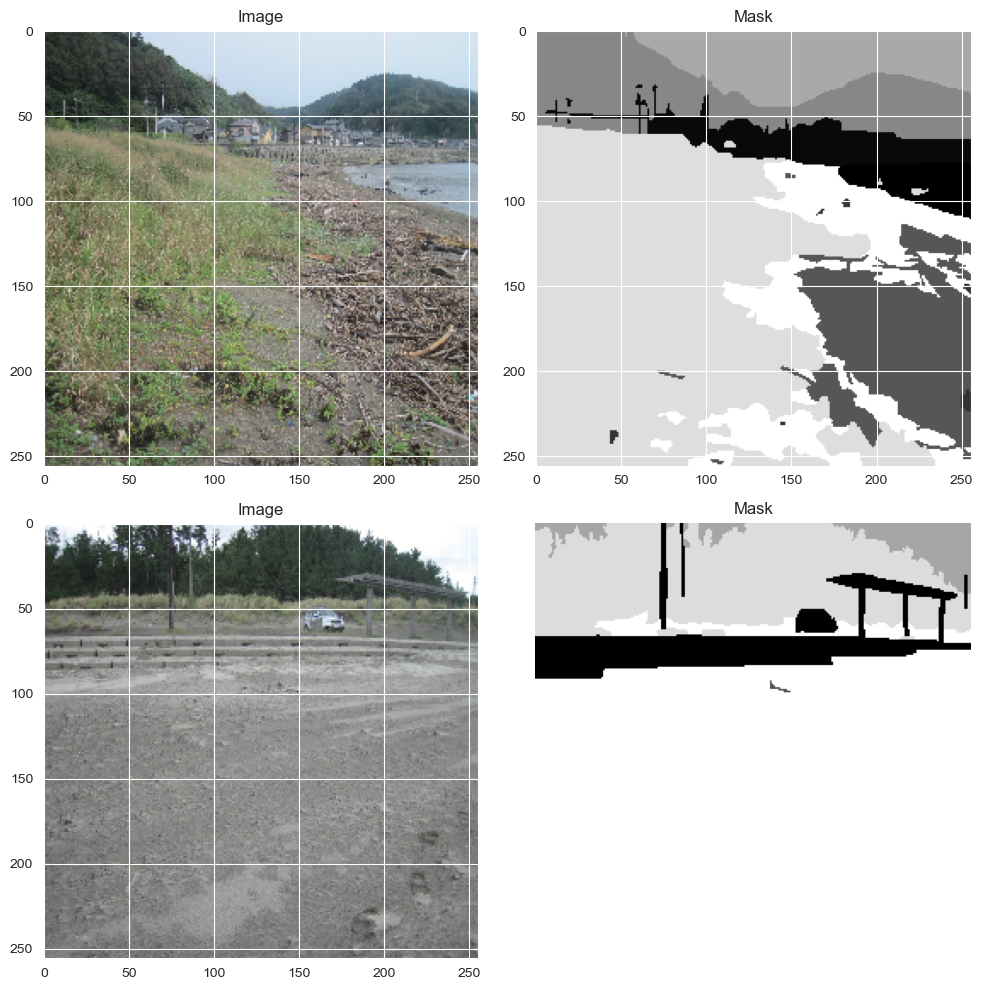

In [38]:
def visualize_data(image_dir, mask_dir, num_examples=2):
    image_files = os.listdir(image_dir)
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    
    for i in range(num_examples):
        img_name = random.choice(image_files)
        img_base_name = os.path.splitext(img_name)[0]
        
        img_path = os.path.join(image_dir, img_name)
        mask_name = mask_files.get(img_base_name, None)
        
        if not mask_name:
            print(f"Mask not found for {img_name}")
            continue
        
        mask_path = os.path.join(mask_dir, mask_name)
        
        image = img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        
    plt.tight_layout()
    plt.axis('off')
    plt.show()

visualize_data('./Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images', './Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs')


### Process images - Research paper states 4:3 aspect ratio for more than 95% of the images

In [80]:
images_ds = tf.data.Dataset.list_files(os.path.join(X_dir, "/*"), shuffle=False)
masks_ds = tf.data.Dataset.list_files(os.path.join(y_dir, "/*"), shuffle=False)

print(f'Type of images_ds {type(images_ds)}')
print(f'Type of masks_ds {type(masks_ds)}')

Type of images_ds <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
Type of masks_ds <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [81]:
# tf.io.read_file('Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images/000000.jpg') 

In [85]:
target_width = 400  # 4:3 aspect ratio as given by the research file
target_height = 300

def resize_crop(image_path):

    img = tf.io.read_file(image_path)
    decoded_img = tf.image.decode_image(img)
    # Explicitly set the shape to avoid Value Error
    decoded_img.set_shape([None, None, 3])
    resized_img = tf.image.resize(decoded_img, [target_height, target_width]) # height then width 
    
    return resized_img

# Applying the resizing to every image in images and masks
def resize_crop_all(images, masks):
    resized_image_tensor = images.map(resize_crop, num_parallel_calls=tf.data.AUTOTUNE) # gpu
    resized_masks_tensor = masks.map(resize_crop, num_parallel_calls=tf.data.AUTOTUNE)
    
    return resized_image_tensor, resized_masks_tensor

def normalize(image):
    # Normalize image
    return tf.cast(image, tf.float32) / 255. # [0 - 1] range


def normalize_all(images, masks):
    normalized_image_tensor = images.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    normalized_masks_tensor = masks.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    
    return normalized_image_tensor, normalized_masks_tensor

In [86]:
resized_imgs, resized_masks = resize_crop_all(images_ds, masks_ds)
img_tensor, masks_tensor = normalize_all(resized_imgs, resized_masks)

In [88]:
print(resized_masks)
print(img_tensor)

<ParallelMapDataset element_spec=TensorSpec(shape=(300, 400, 3), dtype=tf.float32, name=None)>
<ParallelMapDataset element_spec=TensorSpec(shape=(300, 400, 3), dtype=tf.float32, name=None)>


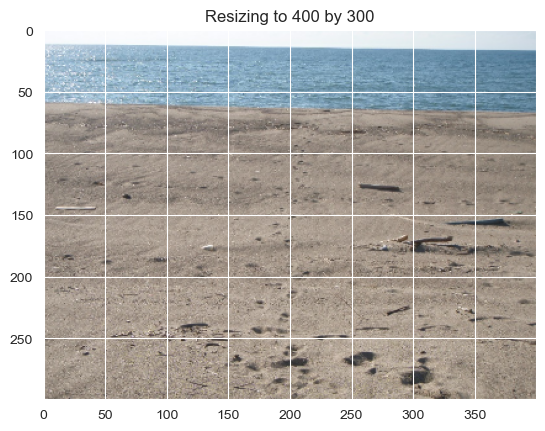

In [89]:
# Test to see if resizing is working on one example
data = resize_crop('Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images/000000.jpg')
data = data.numpy().astype(np.uint8)

plt.imshow(data)
plt.title('Resizing to 400 by 300')
plt.show()

#### Experimental Resizing and cropping images on disk rather than memory

In [7]:
target_width = 400  # 4:3 aspect ratio as given by the research file
target_height = 300

def resize_and_crop(image_path, output_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    aspect_ratio = width / float(height)

    if aspect_ratio > 4/3:
        new_width = int(target_height * aspect_ratio)
        img = cv2.resize(img, (new_width, target_height), interpolation=cv2.INTER_AREA)
        start = (new_width - target_width) // 2
        img = img[:, start:start + target_width]
    else:
        new_height = int(target_width / aspect_ratio)
        img = cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)
        start = (new_height - target_height) // 2
        img = img[start:start + target_height, :]

    cv2.imwrite(output_path, img)

In [8]:
# Iterate over images in X_dir and y_dir, apply resize_and_crop function
for filename in os.listdir(X_dir):
    if filename.endswith(".jpg"):  
        img_path = os.path.join(X_dir, filename)
        output_path = os.path.join(X_path, f"train_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

for filename in os.listdir(y_dir):
    if filename.endswith(".png"): 
        img_path = os.path.join(y_dir, filename)
        output_path = os.path.join(y_path, f"test_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

#### Normalizing

In [5]:
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for image_file, mask_file in zip(image_files, mask_files):
        # Get the image paths
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Load images
        image = load_img(image_path, color_mode='rgb')
        mask = load_img(mask_path, color_mode='rgb')
    
        # Normalize each image
        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
    
        images.append(image)
        masks.append(mask)
        
    # Return array of the normalized images and masks
    return np.array(images), np.array(masks) 

#### Note the order is (number of images, height, width, color channels)

In [6]:
image_array, mask_array = load_images_and_masks(X_path, y_path)
print(f'Image array dim {image_array.shape}')
print(f'Mask array dim {mask_array.shape}')

Image array dim (3500, 300, 400, 3)
Mask array dim (3500, 300, 400, 3)


### Preparing data
#### Train test split

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_array, mask_array, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

#### Data Augmentation

In [ ]:
# Data generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#### Hyperparameters

In [ ]:
EPOCHS=15
BATCH_SIZE = 64

LEARNING_RATE = 0.001

train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

### U-net Neural Network Architecture
#### The U-net architecture is very good at image segmentation and originally developed for biomedical applications, but now can be used for segmenting trash in ocean cleanups!
#### Here we are using the categorical crossentropy loss for multi-segmentation classification

In [13]:
def unet_model(input_size=(300, 400, 3)):
    inputs = layers.Input(input_size)  # (300, 400, 3)

    # Encoding path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)  # (300, 400, 64)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)  # (300, 400, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # (150, 200, 64)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)  # (150, 200, 128)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)  # (150, 200, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # (75, 100, 128)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)  # (75, 100, 256)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)  # (75, 100, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # (37, 50, 256)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)  # (37, 50, 512)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)  # (37, 50, 512)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)  # (18, 25, 512)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)  # (18, 25, 1024)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)  # (18, 25, 1024)

    # Decoding path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)  # (36, 50, 512)
    u6 = layers.concatenate([u6, c4])  # (37, 50, 1024)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)  # (37, 50, 512)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)  # (37, 50, 512)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)  # (74, 100, 256)
    u7 = layers.concatenate([u7, c3])  # (75, 100, 512)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)  # (75, 100, 256)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)  # (75, 100, 256)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)  # (150, 200, 128)
    u8 = layers.concatenate([u8, c2])  # (150, 200, 256)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)  # (150, 200, 128)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)  # (150, 200, 128)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)  # (300, 400, 64)
    u9 = layers.concatenate([u9, c1])  # (300, 400, 128)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)  # (300, 400, 64)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)  # (300, 400, 64)

    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c9)  # (300, 400, 3)

    model = models.Model(inputs=[inputs], outputs=[outputs], name='U-Net')
    
    return model

SyntaxError: invalid syntax (3861111154.py, line 47)

In [ ]:
# Create the U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

#### Model compilation

In [60]:
# Compile and train your model using train_generator
model = unet_model((300, 400, 3))
model.fit(train_generator, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 36, 50, 512), (None, 37, 50, 512)]

Helper code if things break:

In [ ]:
# import os
# 
# # Define the directory path
# directory = X_dir
# 
# # Iterate over files in the directory
# for filename in os.listdir(directory):
#     if "train" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")
# 
# directory = y_dir
# 
# for filename in os.listdir(directory):
#     if "test" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")

'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X'